In [134]:
import numpy as np
import math
import os

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ripser import ripser
from persim import plot_diagrams

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [19]:
smap = cfg['raster_params']

In [234]:
scenes = train_zarr.scenes
frames = train_zarr.frames
agents = train_zarr.agents

In [236]:
frames[1]

(1572643684901714926, [38, 85], [0, 0], [  681.18560791, -2182.42236328,   288.60812378], [[ 0.54708129, -0.83705974,  0.0057475 ], [ 0.83509791,  0.54530114, -0.07251312], [ 0.05756369,  0.0444703 ,  0.99735087]])

In [216]:
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_blank', 'ego_translation','ego_rotation'], array))

def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))

def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'], array))

In [229]:
scenes = [map_scene_array_to_dict(s) for s in train_zarr.scenes]
frames = [map_frame_array_to_dict(f) for f in train_zarr.frames]
agents = [map_agent_array_to_dict(a) for a in train_zarr.agents]

In [218]:
frames[0]

{'timestamp': 1572643684801892606,
 'agent_index_interval': array([ 0, 38], dtype=int64),
 'ego_blank': array([0, 0], dtype=int64),
 'ego_translation': array([  680.61975098, -2183.32763672,   288.5411377 ]),
 'ego_rotation': array([[ 0.54673314, -0.83729434,  0.00459086],
        [ 0.83528739,  0.54502565, -0.07240184],
        [ 0.05811952,  0.04341917,  0.997365  ]])}

In [230]:
def getAgentData(scene,frames):
    coords = np.zeros((2000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0],2)) #2000 is arbitrary number
    vels = -1 * np.ones((2000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0],2)) #2000 is arbitrary number
    tags = -1 * np.ones((2000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0])) #2000 is arbitrary number
    yaws = 2 * np.ones((2000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0])) #2000 is arbitrary number
    for frame_counter,frame_num in enumerate(tqdm(range(scene['frame_index_interval'][0],scene['frame_index_interval'][1]))):
        frame = frames[frame_num]
        coords[0][frame_counter] = frame['ego_translation'][:2]
        yaws[0][frame_counter] = math.acos(frame['ego_rotation'][0][0])
        for j in range(frame['agent_index_interval'][0],frame['agent_index_interval'][1]):
            agent = agents[j]
            coords[agent['track_id']][frame_counter] = agent['centroid']
            vels[agent['track_id']][frame_counter] = agent['velocity']
            tags[agent['track_id']][frame_counter] = j
            yaws[agent['track_id']][frame_counter] = agent['yaw']
    return coords,vels,tags.astype(int),yaws

def getWithout(arr,n):
    return arr[arr!=n]

def getAverageSpeed(agent_num,vels):
    return np.mean(getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

In [231]:
coords,vels,tags,yaws = getAgentData(scenes[0],frames)

100%|██████████████████████████████████████| 248/248 [00:00<00:00, 4592.78it/s]


In [233]:
yaws[1]

array([1.01667511, 0.98688865, 1.00789452, 0.9998908 , 0.99614418,
       0.9935987 , 0.99629426, 0.99551356, 0.99476779, 0.99396586,
       0.99320209, 0.99196154, 0.99131358, 0.99065399, 0.9899767 ,
       0.98919755, 0.9885059 , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.     

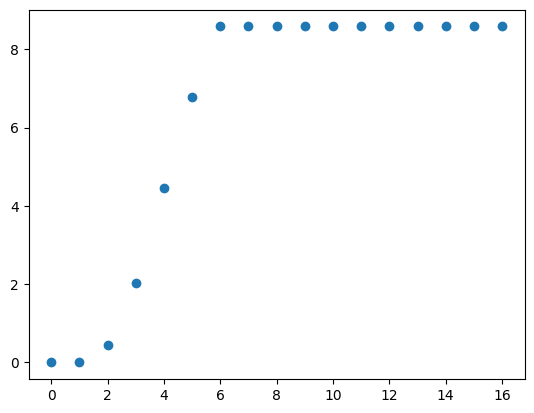

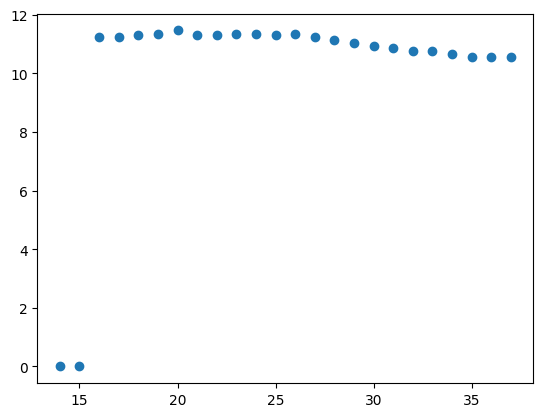

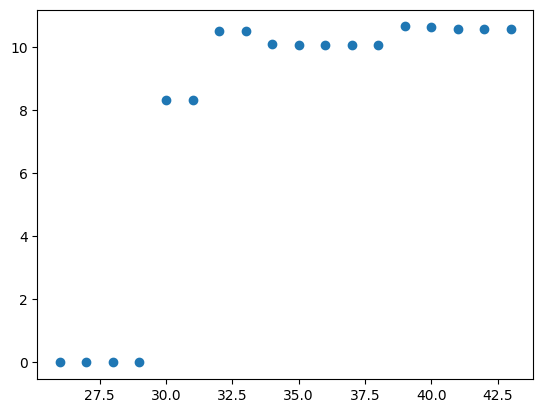

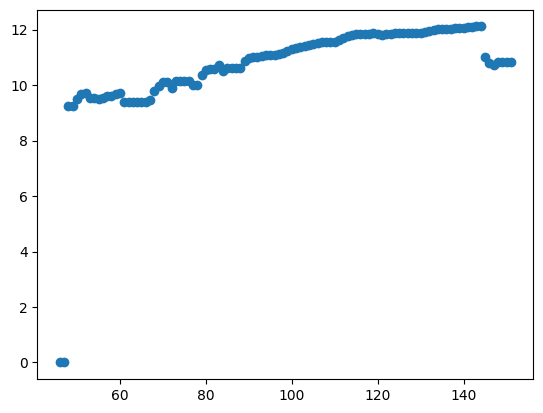

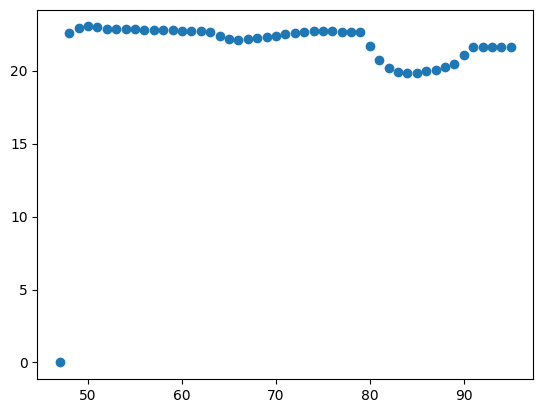

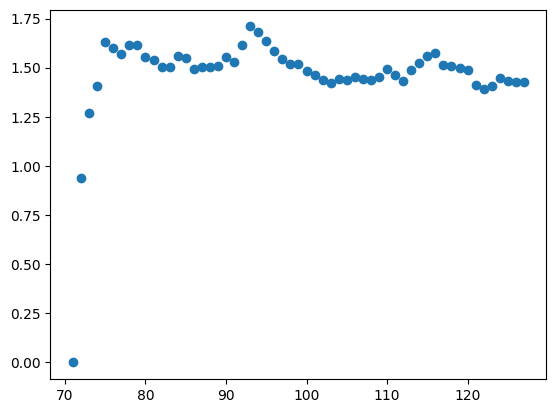

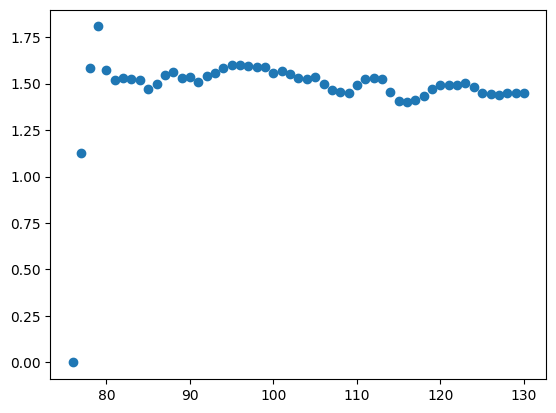

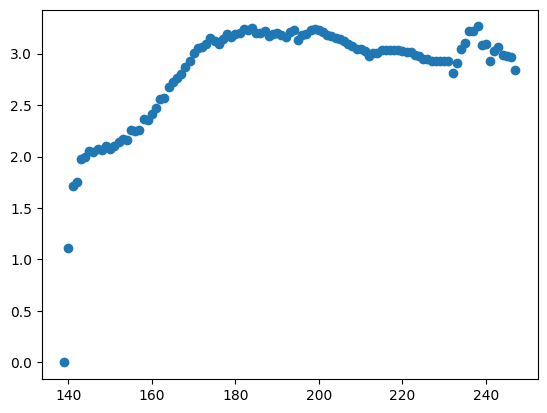

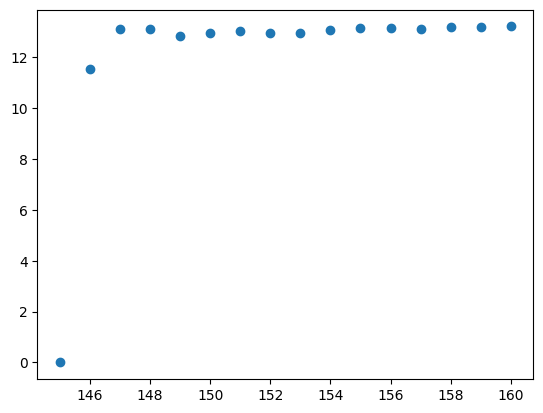

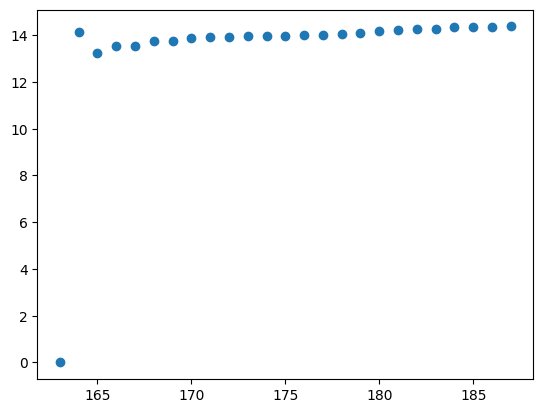

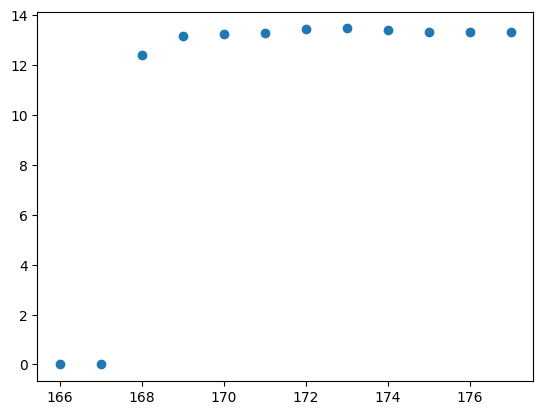

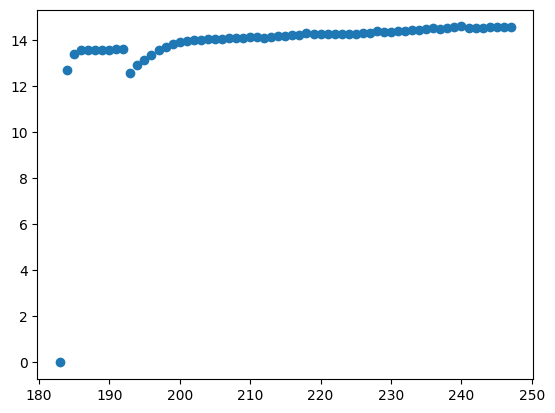

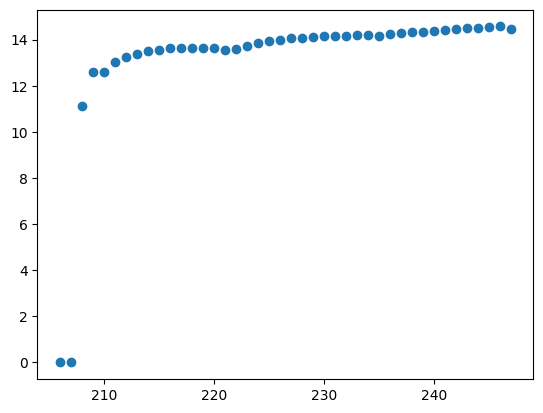

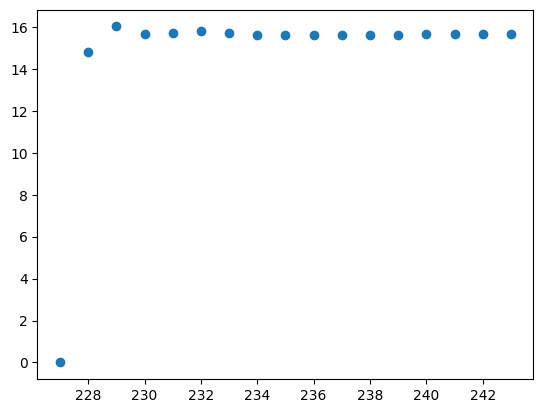

In [200]:
for agent_num in range(len(tags)):
    if len(getWithout(tags[agent_num],-1))>10 and getAverageSpeed(agent_num,vels)>1:
        plotAgentSpeed(agent_num,vels)
        #dens = getAgentDensities(agent_num,tags,agents,frames,3,[0,0])
        #plotAgentDensity(dens)

In [139]:
def getDensitiesAll(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num]['agent_index_interval'][1]-frames[frame_num]['agent_index_interval'][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num]['agent_index_interval'][0],frames[frame_num]['agent_index_interval'][1])):
            #print(distance_from_edge(agents[agent_index],agents[pos[frame_num]]))
            #print(distance_from_center(agents[agent_index],agents[pos[frame_num]]))
            temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
        densities.append(temp)
    return np.array(densities,dtype = object)

def getDensitiesMoving(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num]['agent_index_interval'][1]-frames[frame_num]['agent_index_interval'][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num]['agent_index_interval'][0],frames[frame_num]['agent_index_interval'][1])):
            if math.hypot(agents[agent_index]['velocity'][0],agents[agent_index]['velocity'][1]) > 1:
                temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
            else:
                temp[agent_count] = 1000
        densities.append(temp)
    return np.array(densities,dtype = object)

def returnDensitiesDistances(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = np.sort(densities[frame_num])[k+1]
    return dist_densities

def returnDensitiesRadius(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = (densities[frame_num]<k).sum()
    return dist_densities

def getAgentDensities(agent_num,tags,agents,frames,k,t):
    if t[0] == 0:
        densities = getDensitiesAll(agent_num,tags,agents,frames)
    else:
        densities = getDensitiesMoving(agent_num,tags,agents,frames)
    if t[1] == 0:
        ret = returnDensitiesDistances(densities,k)
    else:
        ret = returnDensitiesRadius(densities,k)
    return ret

In [171]:
def plotAgentPos(agent_num,coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(coords[agent_num][:,0],0),getWithout(coords[agent_num][:,1],0),zs = np.arange(len(coords[agent_num]))[coords[agent_num][:,0]!=0],s=3)
    plt.show()
    
def plotAgentVel(agent_num,vels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(vels[agent_num][:,0],-1),getWithout(vels[agent_num][:,1],-1),zs = np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],s=3)
    plt.show()
    
def plotAgentSpeed(agent_num,vels):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def plotAgentDensity(agent_density):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(agent_density))[agent_density!=-1],getWithout(agent_density,-1))

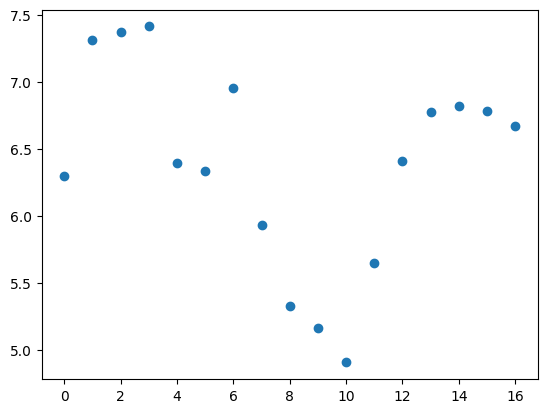

In [143]:
plotAgentDensity(dens)

In [144]:
dens

array([ 6.297826  ,  7.31426575,  7.36948213,  7.41169619,  6.39400958,
        6.33595929,  6.95334744,  5.93526378,  5.3281503 ,  5.16704652,
        4.90759468,  5.6503942 ,  6.41021862,  6.77365247,  6.81883551,
        6.7851746 ,  6.67340792, -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

In [140]:
dens = getAgentDensities(1,tags,agents,frames,3,[0,0])

In [52]:
vels[1]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.23517583,  0.37267229],
       [ 1.01263988,  1.74916482],
       [ 2.2948935 ,  3.8041594 ],
       [ 3.52881384,  5.80122185],
       [ 4.27606678,  7.43839359],
       [ 4.27609444,  7.43843794],
       [ 4.27585411,  7.43861198],
       [ 4.27602816,  7.43853426],
       [ 4.27591991,  7.4386096 ],
       [ 4.27936029,  7.43663883],
       [ 4.27839565,  7.43719864],
       [ 4.2775197 ,  7.43770552],
       [ 4.27677631,  7.43813467],
       [ 4.27679014,  7.43812799],
       [ 4.2761507 ,  7.43849611],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        ,

In [51]:
getAgentDensities(1,tags,agents,frames,1,[0,0])

array([3.94318379, 4.06797361, 4.03475851, 3.97023813, 3.44377984,
       2.62880611, 3.1361793 , 3.71996543, 3.49935208, 4.1999733 ,
       4.35825194, 3.93083978, 3.50336864, 3.43085643, 3.12693666,
       2.79918965, 3.88371377, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [40]:
getDensitiesMoving(1,coords,frames)

array([array([1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        ,   23.52555609,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        ]),
       array([1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        ,   37.61337994, 1000.        , 1000.        ,
       10

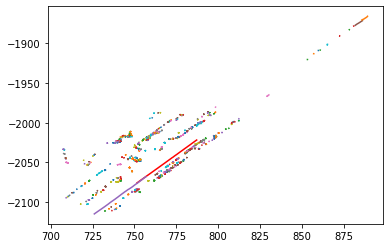

In [119]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,100:150,0], coords[0,100:150, 1],color = 'red')
for j in range(1,2000):
    #if (coords[j,:99,0]!=0).sum()>50:
    plt.plot(getWithout(coords[j,100:150,0],0),getWithout(coords[j,100:150,1],0))

plt.show()


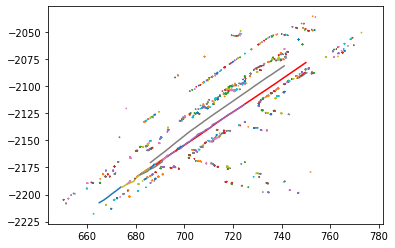

In [15]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,:99,0], coords[0,:99, 1],color = 'red')
for j in range(1,2000):
    #if (coords[j,:99,0]!=0).sum()>50:
    plt.plot(getWithout(coords[j,:99,0],0),getWithout(coords[j,:99,1],0))

plt.show()


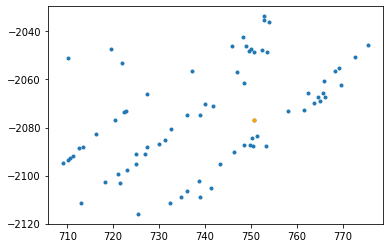

In [14]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,99,0], coords[0,99, 1],color = 'orange',marker = '.')

ax.scatter(getWithout(coords[:,99,0],0),getWithout(coords[:,99,1],0),marker = '.')

plt.show()


In [251]:
for agent in agents[1000:10000]:
    print(agent['label_probabilities'].nonzero()[0][0]!=1 and agent['label_probabilities'].nonzero()[0][0]!=3)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

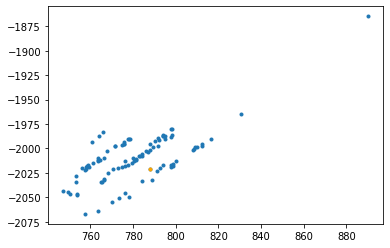

In [17]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,150,0], coords[0,150, 1],color = 'orange',marker = '.')

ax.scatter(getWithout(coords[:,150,0],0),getWithout(coords[:,150,1],0),marker = '.')

plt.show()

In [7]:
def getVelocity(scene,frames):
    coords = -1 * np.ones((2000,scene[0][1]-scene[0][0],2))
    for i in tqdm(range(scene[0][0],scene[0][1])):
        frame = frames[i]
        for j in range(frame[1][0],frame[1][1]):
            agent = agents[j]
            coords[agent[-2]][i-scene[0][0]] = agent[3]
    return coords

100%|████████████████████████████████████████| 249/249 [02:08<00:00,  1.93it/s]


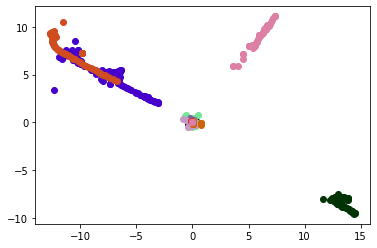

In [10]:
vels = getVelocity(scenes[1],frames)
graphVelocity(vels)

In [12]:
agents[0]

([  665.03424072, -2207.51220703], [4.3913283, 1.8138304, 1.5909758], 1.0166751, [0., 0.], 1, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [129]:
def getProfile(agent_num,vels):
    vel = vels[agent_num]
    
    X = np.zeros((len(getWithout(vel[:,0],-1)),2))
    X[:,0] = (np.arange(len(vel[:,0]))[vel[:,0]!=-1])
    X[:,1] = (getWithout(vel[:,0],-1)**2 + getWithout(vel[:,1],-1)**2)**0.5
    
    dgms = ripser(X)['dgms']

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter((np.arange(len(vel[:,0]))[vel[:,0]!=-1]),(getWithout(vel[:,0],-1)**2 + getWithout(vel[:,1],-1)**2)**0.5)

    plt.title("Point Cloud")
    plt.subplot(122)
    plot_diagrams(dgms)
    plt.show()
    return X

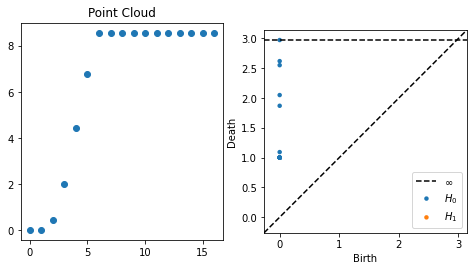

In [132]:
X = getProfile(1,vels)

In [9]:
def graphVelocity(coords):
    fig,ax = plt.subplots()
    for j in range(1,2000):
        if (coords[j,:,0]!=-1).sum() > 50:
            ax.scatter(coords[j,:,0][coords[j,:,0]!=-1],coords[j,:,1][coords[j,:,1]!=-1],color = ((j%1000)/1000.0,(j%10)/10.0,(j%100)/100.0),label = j)

    #ax.legend()
    plt.show()

In [39]:
def distance_from_center(agent1, agent2):
    '''
    Calculates the distance between the centroids of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distk ance between the two agents' centroids
    '''
    return np.linalg.norm(agent1['centroid'] - agent2['centroid'])

In [38]:
def distance_from_edge(agent1, agent2):
    '''
    Calculates the distance between the closest edges of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distance between two agents' closest edges
    '''
        
    # generate orthogonal axes for each agent
    a1_length_axis = agent1['extent'][1] / 2 * np.array([np.cos(agent1['yaw']), np.sin(agent1['yaw'])])
    a1_width_axis  = agent1['extent'][0] / 2 * np.array([np.sin(agent1['yaw']), np.cos(agent1['yaw'])])
    a2_length_axis = agent2['extent'][1] / 2 * np.array([np.cos(agent2['yaw']), np.sin(agent2['yaw'])])
    a2_width_axis  = agent2['extent'][0] / 2 * np.array([np.sin(agent2['yaw']), np.cos(agent2['yaw'])])
        
    # find all of the corners
    a1_corners = np.asarray([agent1['centroid'] + a1_length_axis * a + a1_width_axis * a for a in [-1, 1]])
    a2_corners = np.asarray([agent2['centroid'] + a2_length_axis * a + a2_width_axis * a for a in [-1, 1]])
    
    # convert corners into cartesian intervals
    a1_max = np.maximum(*a1_corners)
    a1_min = np.minimum(*a1_corners)
    a2_max = np.maximum(*a2_corners)
    a2_min = np.minimum(*a2_corners)
    
    # compute minkowski distance for rectangles
    y = np.maximum(0, np.maximum(a1_min - a2_max, a2_min - a1_max))
    
    return np.sum(np.abs(y) ** 2, axis=-1) ** (1/2)

In [8]:
distance_from_center(dataset[1], dataset[5])

88.71618250270556

In [9]:
distance_from_edge(dataset[1], dataset[5])

85.06367486122527